In [1]:
from scipy import special

In [2]:
# %load mean_field_model.py
import attr
import numpy as np

# SI base units
s = 1
kg = 1
m = 1
A = 1

# derived units
S = s**3*A**2/(kg*m**2)
V = kg*m**2*s**-3*A**-1
F = s**4 * A**2 * m**-2 * kg ** -1
Hz = 1/s

# with prefixes
nS = 1e-9 * S
uS = 1e-6 * S
mV = 1e-3 * V
uV = 1e-6 * V
pF = 1e-12 * F
ms = 1e-3 * s
nA = 1e-9 * A
pA = 1e-12 * A


def kuhn_transfer_function(threshold, tau_eff, mu_u, sigma_sq_u):
    return 1. / (2 * tau_eff) * (special.erfc((threshold - mu_u) /
                                 (np.sqrt(2) * np.sqrt(sigma_sq_u))))


def derivative_kuhn_transfer_function(threshold, tau_eff,  mu_u, sigma_sq_u):
    return 1. / (2 * tau_eff * (np.sqrt(2 * sigma_sq_u)) * (2/ np.sqrt(np.pi)) *
                 np.exp(-(threshold - mu_u) ** 2 / (2 * sigma_sq_u)))


@attr.s
class EIMeanField:
    E_e = attr.ib(0 * mV)
    E_i = attr.ib(-75 * mV)
    E_l = attr.ib(-70 * mV)
    g_l = attr.ib(1./60 * uS)
    C = attr.ib(250 * pF)
    v_reset = attr.ib(-60 * mV)
    threshold = attr.ib(-50 * mV)
    threshold_inh = attr.ib(-53 * mV)
    tau_ref = attr.ib(2 * ms)
    T_e = attr.ib(0.2 * ms)  # width of excitatory PSC (ms)
    T_i = attr.ib(2 * ms)    # width of inhibitory PSC (ms)
    tau_e = attr.ib(1 * ms)  # timescale of excitatory population (ms)
    tau_i = attr.ib(0.5 * ms)    # timescale of inhibitory population (ms)
    B_e = attr.ib(7.1 * nS)    # peak excitatory conductance (nS)
    B_i = attr.ib(3.7 * nS)    # peak inhibitory conductance (nS)

    f_ext = attr.ib(5000 * Hz) # etracellular_firing_rate

    n_e = attr.ib(350.) # number of excitatory neurons
    n_i = attr.ib(350. / 4.) # number of inhibitory neurons

    noise_std_e = attr.ib(2000 * Hz / np.sqrt(s))
    noise_std_i = attr.ib(0 * Hz / np.sqrt(s))

    tau_adapt = attr.ib(800 * ms) # adaptation time constant
    beta_adapt = attr.ib(0.00005*mV / Hz) # strength of adaptation (per firing rate of E population)

    def calc_membrane_stats(self, fr_e, fr_i):

        mu_ge = fr_e * self.B_e * self.T_e * np.exp(1)
        mu_gi = fr_i * self.B_i * self.T_i * np.exp(1)

        gtot = self.g_l + mu_ge + mu_gi

        mu_u = (self.E_l * self.g_l + self.E_e * mu_ge + self.E_i * mu_gi) / gtot

        tau_eff = self.C / gtot

        epsp_int = (self.E_e - mu_u) * self.B_e * self.T_e * np.exp(1) * tau_eff / self.C
        ipsp_int = (self.E_i - mu_u) * (self.B_i * self.T_i * np.exp(1) * tau_eff / self.C)
        epsp_sq =  epsp_int ** 2 * (2 * tau_eff + self.T_e) /(4 * (tau_eff + self.T_e)**2)
        ipsp_sq =  ipsp_int ** 2 * (2 * tau_eff + self.T_i) /(4 * (tau_eff + self.T_i)**2)
        sigma_sq_u = fr_e * epsp_sq + fr_i * ipsp_sq

        return gtot, mu_u, tau_eff, sigma_sq_u



    def calc_output_rate_inh_exc(self, fr_e, fr_i, delta_v_e=0, delta_v_i=0):
        gtot_exc, mu_u_exc, tau_eff_exc, sigma_sq_u_exc = self.calc_membrane_stats(fr_e=fr_e, fr_i=fr_i)
        gtot_inh, mu_u_inh, tau_eff_inh, sigma_sq_u_inh = self.calc_membrane_stats(fr_e=fr_e, fr_i=fr_i)

        rexc = kuhn_transfer_function(self.threshold + delta_v_e, tau_eff_exc, mu_u_exc, sigma_sq_u_exc)
        rinh = kuhn_transfer_function(self.threshold_inh + delta_v_i, tau_eff_inh, mu_u_inh, sigma_sq_u_inh)

        return rexc * self.n_e, rinh * self.n_i

    def ode_step(self, dt, rexc, rinh, theta_adapt, dv_e=0, dv_i=0):
        fexc, finh = self.calc_output_rate_inh_exc(rexc + self.f_ext,
                              rinh, theta_adapt + dv_e, dv_i)
        theta_adapt = theta_adapt + ((-theta_adapt +
                 self.beta_adapt * rexc) *
                 dt / self.tau_adapt)
        rinh = rinh + (-rinh + finh) * dt / self.tau_i
        rexc = rexc + (-rexc + fexc) * dt / self.tau_e


        return rexc, rinh, theta_adapt

    def sde_step(self, dt, rexc, rinh, theta_adapt, dv_e=0, dv_i=0):
        rexc, rinh, theta_adapt = self.ode_step(dt, rexc, rinh, theta_adapt, dv_e, dv_i)
        rexc += np.random.randn() * self.noise_std_e * np.sqrt(dt)
        rinh += np.random.randn() * self.noise_std_i * np.sqrt(dt)
        rexc = np.maximum(rexc, 0)
        rinh = np.maximum(rinh, 0)

        return rexc, rinh, theta_adapt


## One population : 1 Hz oscillations

In [3]:
import matplotlib.pyplot as plt

In [4]:
tau_adapt = 800 * ms # adaptation time constant
beta_adapt = 0.00005*mV / Hz # strength of adaptation (per firing rate of E population)
dt = 1. * ms # integration time step
tau_e = 10*ms # time constant of excitatory population
tau_i = 5* ms # time constant of inhibitory population
threshold_inh0 = -51 * mV # inhibitory threshold
noise_e = 2000 * Hz / s 
tmax = 20 * s
f_ext = 1000 * Hz

In [5]:
model = EIMeanField(tau_adapt=tau_adapt,
                    beta_adapt=beta_adapt,
                    tau_e=tau_e,
                    tau_i=tau_i,
                    threshold_inh=threshold_inh0,
                    noise_std_e=noise_e,
                    noise_std_i=0,
                    f_ext=f_ext
                    )

In [6]:
np.random.seed(100)
rexc = 100 * Hz
rinh = 100 * Hz
theta_adapt = 0 * mV
t = 0
solution = []
while t < tmax:
    rexc, rinh, theta_adapt = model.sde_step(dt, rexc, rinh, theta_adapt)
    t += dt
    solution.append((rexc, rinh, theta_adapt))
solution = np.array(solution)
time = np.arange(solution.shape[0]) * dt

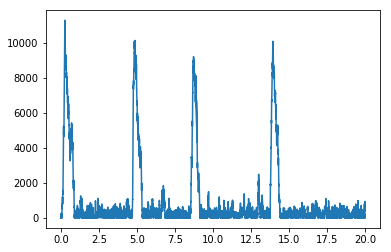

In [7]:
plt.plot(time[:], solution[:, 0])

## Two coupled populations

In [8]:
def run_two_coupled_populations(tmax, model, gamma_ephaptic):
    
    states = np.zeros((2, 3))
    states[:, 0] = 100 * Hz
    states[:, 1] = 100 * Hz
    t = 0
    solution = []
    while t < tmax:
        states[0, :] = model.sde_step(dt, *states[0, :], -states[1, 0] * gamma_ephaptic)
        states[1, :] = model.sde_step(dt, *states[1, :], -states[0, 0] * gamma_ephaptic)
        t += dt
        solution.append(states.copy())
    solution = np.array(solution)
    time = np.arange(solution.shape[0]) * dt
    return time, solution

In [9]:
gamma_ephaptic = 10 * uV / (6000*Hz) # ephaptic coupling coefficient
tmax = 100 * s
time, solution = run_two_coupled_populations(tmax, model, gamma_ephaptic)

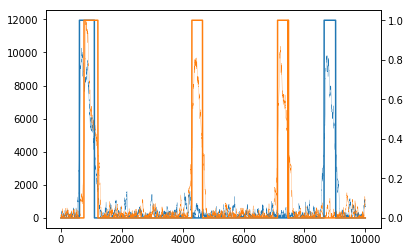

In [10]:
plt.plot(solution[:10000, :, 0], lw=0.25)
plt.twinx()
plt.plot(solution[:10000, :, 0] > 4000)

In [11]:
np.corrcoef((solution[:, :, 0] > 4000).T)

array([[ 1.        , -0.04218763],
       [-0.04218763,  1.        ]])

In [13]:
gamma_arr = np.linspace(0, 60. * uV / (6000*Hz), 10)
threshold = 4000
corr_coef = []
for gamma in gamma_arr:
    time, solution = run_two_coupled_populations(tmax, model, gamma)
    if np.isnan(solution).any() or np.isinf(solution).any():
        corr_coef.append(np.nan)
        continue
    up_state_train = solution[:, :, 0] > threshold
    rmat = np.corrcoef(up_state_train.T)
    mean_duration = np.mean(up_state_train)
    corr_coef.append((rmat[0, 1], mean_duration))
corr_coef = np.array(corr_coef)

Text(0, 0.5, 'corr. coef.')

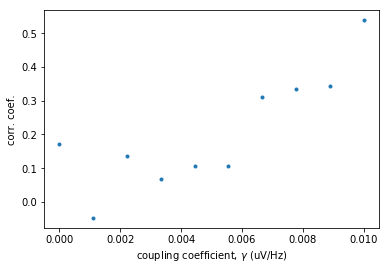

In [14]:
plt.plot(gamma_arr * Hz / uV, corr_coef[:, 0], '.')
plt.xlabel('coupling coefficient, $\gamma$ (uV/Hz)')
plt.ylabel('corr. coef.')